In [1]:
import yasa
import mne
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from closedloop.streamer_class import data_streamer

In [2]:
RAW_DATA_FILE = '../resources/n1_raw.fif'
RAW_EVE_FILE = '../resources/n1_eve.fif'

CHANNELS = ['F4-C4','C4-A1']

# Sampling Frequency 500 Hz

In [3]:
raw = mne.io.read_raw_fif(RAW_DATA_FILE)
events = mne.read_events(RAW_EVE_FILE)
streamer: data_streamer = data_streamer(raw, events)
streamer.chans_sel(CHANNELS)

stages = streamer.staging()

Opening raw data file ../resources/n1_raw.fif...
    Range : 0 ... 17309999 =      0.000 ... 34619.998 secs
Ready.


In [4]:
from closedloop.util import find_value_indices
indices_n3 = find_value_indices(stages, 3)

In [28]:
TIMESLICE = (8445000, 8445000 + 15000)
hypno = stages[TIMESLICE[0]:TIMESLICE[1]]
data_1 = raw.get_data(start=TIMESLICE[0], stop=TIMESLICE[1], picks=CHANNELS)[0] * 1e6
data_2 = raw.get_data(start=TIMESLICE[0], stop=TIMESLICE[1], picks=CHANNELS)[1] * 1e6
data = data_1 + data_2

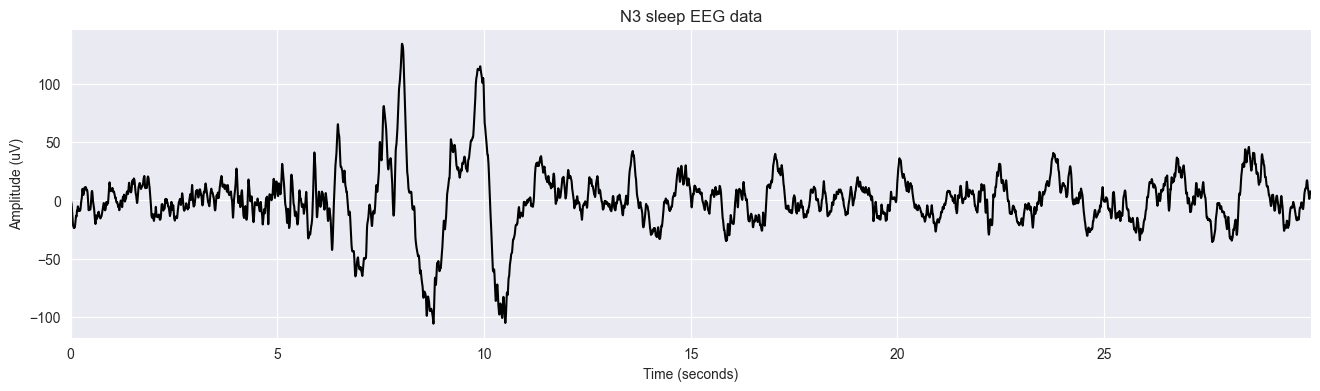

In [29]:
sf = 500.
times = np.arange(data.size) / sf

# Plot the signal
fig, ax = plt.subplots(1, 1, figsize=(16, 4))
plt.plot(times, data, lw=1.5, color='k')
plt.xlabel('Time (seconds)')
plt.ylabel('Amplitude (uV)')
plt.xlim([times.min(), times.max()])
plt.title('N3 sleep EEG data')
sns.despine()

In [58]:
from yasa import sw_detect

# Short version
# sw = sw_detect(data, sf, hypno=hypno)

# Long version (with all the optional implicit arguments)
sw = sw_detect(data, sf, hypno=hypno, include=(2, 3), freq_sw=(0.3, 1.5),
               dur_neg=(0.3, 1.5), dur_pos=(0.1, 1.5), amp_neg=(40, 200),
               amp_pos=(10, 150), amp_ptp=(75, 350), coupling=False,
               remove_outliers=False, verbose=False)

# To get the full detection dataframe, we use the .summary() method
events = sw.summary()
# sw_front.compare_detection(sw_central, other_is_groundtruth=True)
events

,Start,NegPeak,MidCrossing,PosPeak,End,Duration,ValNegPeak,ValPosPeak,PTP,Slope,Frequency,Stage,Channel,IdxChannel
0,6.720,6.998,7.280,7.522,8.278,1.558,-67.972251,30.937829,98.910080,350.744964,0.641849,3,CHAN000,0
1,8.278,8.670,9.084,9.302,10.152,1.874,-92.998541,37.826326,130.824867,316.002094,0.533618,3,CHAN000,0
2,10.152,10.408,11.096,11.382,12.218,2.066,-104.235051,29.340687,133.575738,194.150782,0.484027,3,CHAN000,0


In [59]:
# Let's get a mask indicating for each sample
mask = sw.get_mask()
mask

array([0, 0, 0, ..., 0, 0, 0])

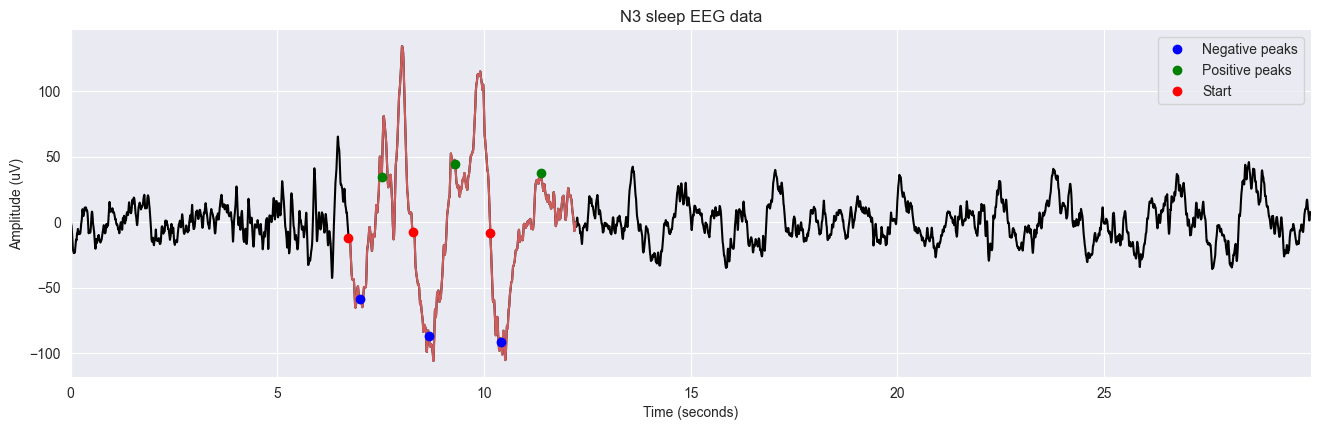

In [60]:
sw_highlight = data * mask
sw_highlight[sw_highlight == 0] = np.nan

plt.figure(figsize=(16, 4.5))

plt.plot(times, data, 'k')
plt.plot(times, sw_highlight, 'indianred')
plt.plot(events['NegPeak'], sw_highlight[(events['NegPeak'] * sf).astype(int)], 'bo', label='Negative peaks')
plt.plot(events['PosPeak'], sw_highlight[(events['PosPeak'] * sf).astype(int)], 'go', label='Positive peaks')
plt.plot(events['Start'], data[(events['Start'] * sf).astype(int)], 'ro', label='Start')

plt.xlabel('Time (seconds)')
plt.ylabel('Amplitude (uV)')
plt.xlim([0, times[-1]])
plt.title('N3 sleep EEG data')
plt.legend()
sns.despine()